In [ ]:
!pip install datasets transformers evaluate accelerate umap-learn umap-learn[plot]

In [2]:
from google.colab import drive
# mount drive to access data
drive.mount('/content/drive')
# load data folder into working directory
!cp -r drive/MyDrive/data .
!cp -r drive/MyDrive/bert_9_layers .

Mounted at /content/drive


In [1]:
from datasets import Dataset
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
 AdamW, TrainingArguments, Trainer
import numpy as np
import evaluate
import torch
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
# loading data with preprocessed tweets
train_df = pd.read_csv('data/bonus_train.csv')
val_df = pd.read_csv('data/bonus_val.csv')
test_df = pd.read_csv('data/bonus_test.csv')

In [3]:
# drop other columns
train_df = train_df[['Labels', 'TweetText']]
val_df = val_df[['Labels', 'TweetText']]
test_df = test_df[['Labels', 'TweetText']]

### Prepare Input for BERT

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [5]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [6]:
def labels2vec(entry):
  label_list = entry['labels'].split()
  one_hot = []
  for i in range(11):
    temp = i
    if str(temp) in label_list:
      one_hot.append(1.0)
    else:
      one_hot.append(0.0)
  entry['labels'] = one_hot
  return entry

In [7]:
def return_dataset(df, select=None):

  dataset = Dataset.from_pandas(df)
  if select is not None:
    dataset = dataset.select(range(select))

  dataset = dataset.rename_column("Labels", "labels")
  dataset = dataset.rename_column("TweetText", "text")

  dataset = dataset.map(tokenize_function, batched=True)

  dataset = dataset.map(labels2vec)

  dataset.set_format("torch")

  return dataset

In [8]:
train_dataset = return_dataset(train_df)
val_dataset = return_dataset(val_df)
test_dataset = return_dataset(test_df)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Label Distribution

In [44]:
full_df = pd.read_csv('data/bonus_cleaned.csv')

In [45]:
def get_labels(df):

  labels_list = df['Labels'].tolist()
  labels = []
  for l in labels_list:
    add = l.split()
    add = (int(i) for i in add)
    labels += add

  return labels

In [46]:
all_labels = get_labels(full_df)

In [47]:
unique, counts = np.unique(all_labels, return_counts=True)
unique

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [48]:
emotions = ['Optimistic', 'Thankful', 'Empathetic', \
            'Pessimistic', 'Anxious', 'Sad', 'Annoyed', \
            'Denial', 'Surprise', 'Official Report', 'Joking']

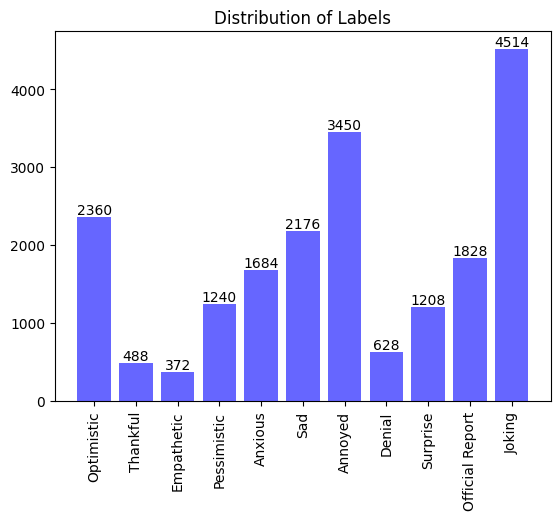

In [49]:
# make bar plot of labels

fig, ax = plt.subplots()

ax.set_title('Distribution of Labels')
ax.set_xticks(range(11))

for i, v in enumerate(counts):
    bar = ax.bar(i, v, color='b', alpha=0.6)
    ax.bar_label(bar, labels=[v])

ax.set_xticklabels(emotions, fontsize=10, rotation='vertical')

plt.savefig('plots/emotion_analysis_labels.png', bbox_inches='tight')
plt.show()

We can see that the 11 classes are not equally distributed. 
Therefore we again decide to use a weighted loss function.
This time our model predicts a vector of 11 outputs for each input.
For each of these outputs we can use a binary cross entropy loss function and then weight the loss of each class by the inverse of its frequency in the training set.
Furthermore the weighted f1 score will again be used as the evaluation metric.

### Class weighted Cross Entropy

In [50]:
train_labels = get_labels(train_df)

In [51]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', \
                                     classes=np.unique(train_labels), \
                                        y=train_labels)

In [ ]:
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

Subclass Trainer to use class weighted cross entropy loss function.

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='none')

class WeightedTrainer(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
      
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0]
        loss = loss_fn(logits, labels)
        loss = class_weights * loss
        loss = torch.mean(loss)
        if return_outputs:
          return (loss, outputs)
        return loss

Load our pretrained model.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert_9_layers")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.classifier = torch.nn.Sequential(torch.nn.Dropout(0.1), \
                                       torch.nn.Linear(768, 11))

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_weighted,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

### Load Model and freeze layers

In [ ]:
# number of unfrozen layers
n = 6

# freeze embeddings and encoder part
for param in model.bert.embeddings.parameters():
  param.requires_grad = False
for param in model.bert.encoder.parameters():
  param.requires_grad = False

# unfreeze top layers of the encoder
for i in range(12-n, 12):
  for param in model.bert.encoder.layer[i].parameters():
    param.requires_grad = True

# gather trainable parameters
params = list(model.bert.pooler.parameters()) \
          + list(model.classifier.parameters())

for i in range(12-n, 12):
  params += list(model.bert.encoder.layer[i].parameters())

# assing trainable parameters to optimizer
optim = AdamW(params=params, lr=5e-5, weight_decay=0.0)

# training arguments
training_args = TrainingArguments(output_dir="test_trainer", \
                                  evaluation_strategy="epoch", \
                                  per_device_eval_batch_size=32, \
                                  per_device_train_batch_size=32, \
                                  num_train_epochs=4.0, \
                                  fp16=True, \
                                  logging_strategy="epoch")

# metric computation
metric = evaluate.load("f1")

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optim, None)
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.295300,0.293579,0.574759,0.716097,0.274000
2,0.244100,0.257004,0.670365,0.777050,0.365000
3,0.189600,0.231078,0.718502,0.805804,0.430000
4,0.157700,0.218508,0.742157,0.820859,0.471000


TrainOutput(global_step=1000, training_loss=0.22167084884643554, metrics={'train_runtime': 753.7616, 'train_samples_per_second': 42.454, 'train_steps_per_second': 1.327, 'total_flos': 8420234133504000.0, 'train_loss': 0.22167084884643554, 'epoch': 4.0})

In [ ]:
!cp -r bert_9_layers drive/MyDrive/bert_9_layers

### Evaluate on testset

In [ ]:
small = train_dataset.select(range(100))

In [ ]:
predictions = trainer.predict(small)

In [ ]:
predictions[0][0]

array([-2.973, -4.766, -3.672, -2.482,  2.791, -2.33 , -3.06 , -4.402,
       -5.516, -2.516,  0.75 ], dtype=float16)

In [ ]:
small[0]['labels']

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])

In [ ]:
predictions[2]['test_f1']

0.6318607047397784

### Visualizing Representations

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert_9_layers")
pretrained = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Get 50 positive and 50 neutral samples

In [ ]:
# loading data with preprocessed tweets
full_df = pd.read_csv('data/cleaned_tweets.csv')

In [ ]:
full_df = full_df[['PosSentiment', 'TweetText']]
pos_df = full_df[full_df['PosSentiment'] > 3][:50]
neu_df = full_df[full_df['PosSentiment'] == 1][:50]

In [ ]:
def dataset_from_df(df):

  df = df[['PosSentiment', 'TweetText']]
  dataset = Dataset.from_pandas(df)
  dataset = dataset.rename_column("PosSentiment", "labels")
  dataset = dataset.rename_column("TweetText", "text")
  dataset = dataset.map(tokenize_function, batched=True)
  dataset = dataset.class_encode_column("labels")

  return dataset

In [ ]:
positive = dataset_from_df(pos_df)
neutral = dataset_from_df(neu_df)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/50 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/50 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/50 [00:00<?, ? examples/s]

### Obtain representations

In [ ]:
rep_args = TrainingArguments(output_dir="test_trainer", \
                                  evaluation_strategy="epoch", \
                                  per_device_eval_batch_size=32, \
                                  per_device_train_batch_size=32, \
                                  num_train_epochs=4.0, \
                                  logging_strategy="epoch")

In [ ]:
pos_trainer = Trainer(
    model=model,
    args=rep_args,
    train_dataset=positive
)
neu_trainer = Trainer(
    model=model,
    args=rep_args,
    train_dataset=neutral
)

In [ ]:
pos_dataloader = pos_trainer.get_train_dataloader()
neu_dataloader = neu_trainer.get_train_dataloader()

In [ ]:
def return_representations(model):
  
  model.train()
  model = model.to('cuda')
  pos_representations = torch.empty(0,)
  with torch.no_grad():
    for inputs in pos_dataloader:
      outputs = model.bert(inputs['input_ids'].to('cuda'))
      pos_representations = torch.cat((pos_representations,outputs.last_hidden_state.cpu()))
  neu_representations = torch.empty(0,)
  with torch.no_grad():
    for inputs in neu_dataloader:

      outputs = model.bert(inputs['input_ids'].to('cuda'))
      neu_representations = torch.cat((neu_representations,outputs.last_hidden_state.cpu()))

  pos_representations = torch.flatten(pos_representations, end_dim=1)
  neu_representations = torch.flatten(neu_representations, end_dim=1)
  representations = torch.concat((pos_representations, neu_representations), dim=0)
  representations = representations.numpy()
  labels = ['positive' for i in range(pos_representations.shape[0])] + ['neutral' for i in range(neu_representations.shape[0])]
  hover_df = pd.DataFrame(labels, columns=['category'])

  return (representations, pd.DataFrame(labels, columns=['category']))

In [ ]:
representations, hover_df = return_representations(model)
pre_representations, _ = return_representations(pretrained)

### UMAP

In [ ]:
import matplotlib.pyplot as plt
import umap
import umap.plot

In [ ]:
mapper = []
pre_mapper = []

In [ ]:
for n in [5, 15, 40, 100]:
  mapper.append(umap.UMAP(n_neighbors=n).fit(representations))
  pre_mapper.append(umap.UMAP(n_neighbors=n).fit(pre_representations))

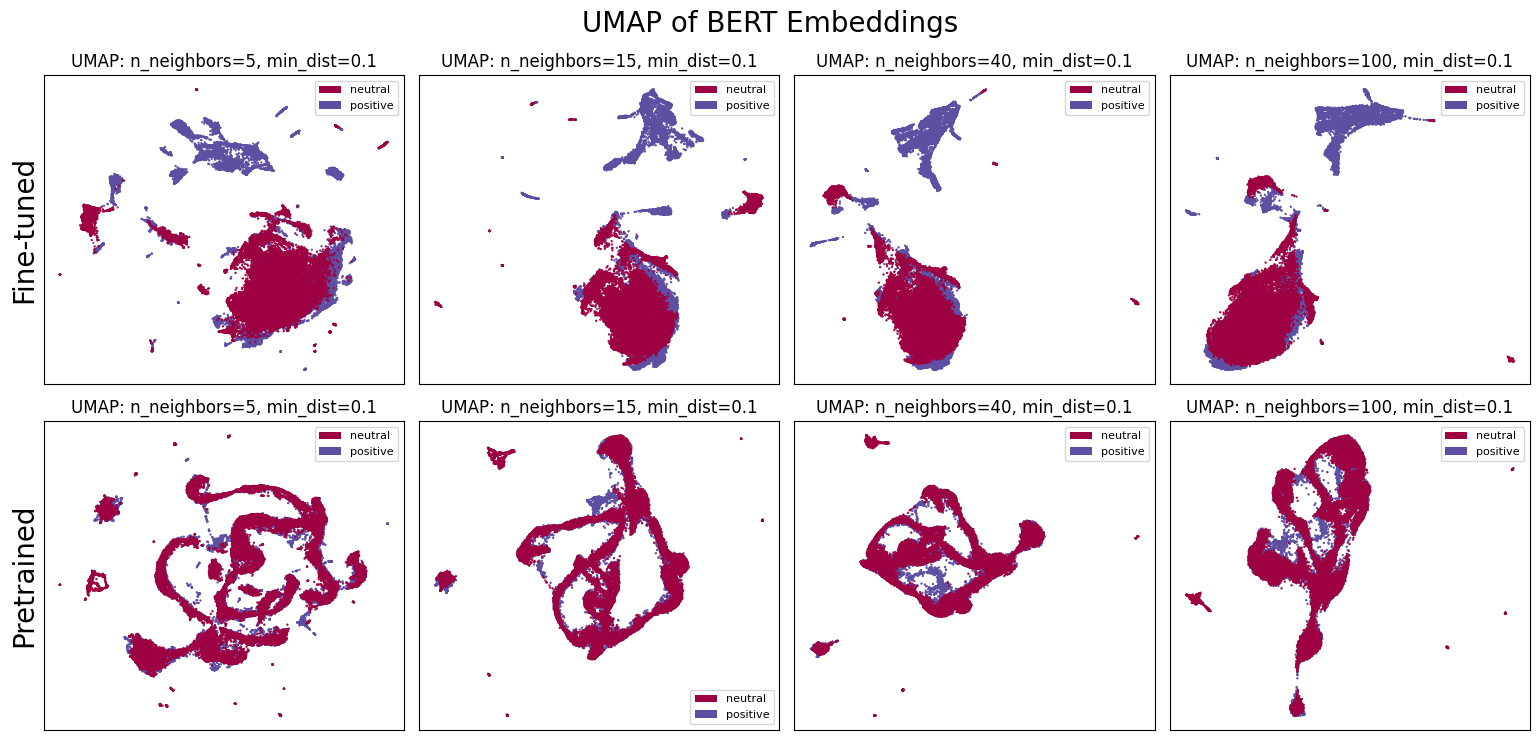

In [ ]:
plt.rcParams['figure.figsize'] = [15.5, 7.5]
plt.rc('legend',fontsize=8)
fig, ax = plt.subplots(2, 4)
neighbors = [5, 15, 40, 100]
neighbors = neighbors + neighbors

for map, n, axis in zip(mapper + pre_mapper, neighbors, ax.ravel()):
  umap.plot.points(map, labels=hover_df['category'], ax=axis)
  for txt in axis.texts:
    txt.set_visible(False)
  axis.set_title("UMAP: n_neighbors=" + str(n) + ", min_dist=0.1", fontsize=12)

ax[0, 0].set_ylabel("Fine-tuned", fontsize=20)
ax[1, 0].set_ylabel("Pretrained", fontsize=20)
fig.suptitle("UMAP of BERT Embeddings", fontsize=20)

plt.tight_layout()
plt.savefig("UMAP_transformer")